# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        for n in self.inputs:
            n.outputs.append(self)
        self.value = None
        self.gradients = {}
    def forward(self):
        raise NotImplemented #raise显示地引发异常。一旦执行了raise语句，raise后面的语句将不能执行
    def backward(self):
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        Node.__init__(self)
    def forward(self, value=None):
        if value is not None:
            self.value = value
    def backward(self):
        self.gradients = {self: 0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs)) #取inputs里的每个元素的value求和

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs, weights) + bias #dot()函数是矩阵乘
    def backward(self):
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs} #zeros_like构造一个维度为n.value的矩阵
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)
            
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))  #exp() 方法返回x的指数
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost * self.partial
    
class MES(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])
    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1) #reshape,改变数组形状，-1代表的意思：不知道分多少行，但必须分成1列
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0] #shape():读取矩阵长度，如shape[0]是读取矩阵第一维的长度
        self.diff = y - a
        self.value = np.mean(self.diff**2)
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff

def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]: #[::-1]相当于 a[-1:-len(a)-1:-1]，也就是从最后一个元素到第一个元素复制一遍，即倒序
        n.backward()
    #return outputnode.value
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0) #pop()将列表指定位置的元素移除，同时可以将移除的元素赋值给某个变量，不填写位置参数则默认删除最后一位
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        if isinstance(n, Input): #isinstance() 函数来判断一个对象是否是一个已知的类型
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def sgd_update(trainables, learning_rate=1e-2):
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample

data = load_boston()
losses = []
X_ = data['data']
y_ = data['target']

X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0) 
#mean()指定轴的算术平均值二维矩阵，axis=0返回纵轴的平均值，axis=1返回横轴的平均值 std()标准差

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MES(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]
print("Total number of examples = {}".format(m))

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
        
        _ = None
        forward_and_backward(_, graph)
        
        rate = 1e-2
        sgd_update(trainables, rate)
        loss += graph[-1].value
    if i % 100 == 0:
        print("Epoch: {}, Loss: {:.2f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 200.65
Epoch: 101, Loss: 8.34
Epoch: 201, Loss: 5.96
Epoch: 301, Loss: 5.83
Epoch: 401, Loss: 5.70
Epoch: 501, Loss: 5.59
Epoch: 601, Loss: 4.74
Epoch: 701, Loss: 6.44
Epoch: 801, Loss: 5.48
Epoch: 901, Loss: 4.70
Epoch: 1001, Loss: 5.79
Epoch: 1101, Loss: 5.53
Epoch: 1201, Loss: 4.40
Epoch: 1301, Loss: 4.81
Epoch: 1401, Loss: 4.46
Epoch: 1501, Loss: 4.17
Epoch: 1601, Loss: 4.38
Epoch: 1701, Loss: 4.17
Epoch: 1801, Loss: 4.35
Epoch: 1901, Loss: 4.30
Epoch: 2001, Loss: 4.57
Epoch: 2101, Loss: 4.92
Epoch: 2201, Loss: 4.50
Epoch: 2301, Loss: 3.92
Epoch: 2401, Loss: 5.67
Epoch: 2501, Loss: 5.02
Epoch: 2601, Loss: 4.99
Epoch: 2701, Loss: 4.62
Epoch: 2801, Loss: 4.59
Epoch: 2901, Loss: 3.81
Epoch: 3001, Loss: 4.34
Epoch: 3101, Loss: 3.71
Epoch: 3201, Loss: 4.75
Epoch: 3301, Loss: 4.36
Epoch: 3401, Loss: 4.68
Epoch: 3501, Loss: 4.00
Epoch: 3601, Loss: 3.98
Epoch: 3701, Loss: 4.65
Epoch: 3801, Loss: 4.13
Epoch: 3901, Loss: 3.81
Epoch: 4001, Loss: 

In [3]:
import matplotlib.pyplot as plt

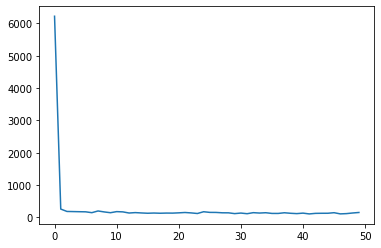

In [4]:
plt.plot(range(len(losses)), losses)

In [5]:
import keras
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

Using TensorFlow backend.


In [6]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 149us/step - loss: 145.2804 - mse: 145.2804
Epoch 2/5000
506/506 [==============================] - 0s 35us/step - loss: 63.9108 - mse: 63.9108
Epoch 3/5000
506/506 [==============================] - 0s 32us/step - loss: 50.5260 - mse: 50.5260
Epoch 4/5000
506/506 [==============================] - 0s 30us/step - loss: 41.1145 - mse: 41.1144
Epoch 5/5000
506/506 [==============================] - 0s 32us/step - loss: 33.4356 - mse: 33.4356
Epoch 6/5000
506/506 [==============================] - 0s 30us/step - loss: 28.1356 - mse: 28.1356
Epoch 7/5000
506/506 [==============================] - 0s 29us/step - loss: 26.0051 - mse: 26.0051
Epoch 8/5000
506/506 [==============================] - 0s 30us/step - loss: 23.5126 - mse: 23.5126
Epoch 9/5000
506/506 [==============================] - 0s 29us/step - loss: 22.0175 - mse: 22.0175
Epoch 10/5000
506/506 [==============================] - 0s 28us/step - loss: 22.1283 - mse: 22.1

506/506 [==============================] - 0s 28us/step - loss: 9.7556 - mse: 9.7556
Epoch 83/5000
506/506 [==============================] - 0s 28us/step - loss: 9.7462 - mse: 9.7462
Epoch 84/5000
506/506 [==============================] - 0s 30us/step - loss: 9.7008 - mse: 9.7008
Epoch 85/5000
506/506 [==============================] - 0s 28us/step - loss: 9.6831 - mse: 9.6831
Epoch 86/5000
506/506 [==============================] - 0s 28us/step - loss: 9.4984 - mse: 9.4984
Epoch 87/5000
506/506 [==============================] - 0s 28us/step - loss: 9.7305 - mse: 9.7305
Epoch 88/5000
506/506 [==============================] - 0s 27us/step - loss: 9.3011 - mse: 9.3011
Epoch 89/5000
506/506 [==============================] - 0s 27us/step - loss: 9.7784 - mse: 9.7784
Epoch 90/5000
506/506 [==============================] - 0s 29us/step - loss: 9.5549 - mse: 9.5549
Epoch 91/5000
506/506 [==============================] - 0s 28us/step - loss: 9.3866 - mse: 9.3866
Epoch 92/5000
506/506 [=

506/506 [==============================] - 0s 28us/step - loss: 6.2639 - mse: 6.2639
Epoch 165/5000
506/506 [==============================] - 0s 27us/step - loss: 6.2034 - mse: 6.2034
Epoch 166/5000
506/506 [==============================] - 0s 27us/step - loss: 6.4019 - mse: 6.4019
Epoch 167/5000
506/506 [==============================] - 0s 27us/step - loss: 6.1821 - mse: 6.1821
Epoch 168/5000
506/506 [==============================] - 0s 27us/step - loss: 6.1592 - mse: 6.1592
Epoch 169/5000
506/506 [==============================] - 0s 26us/step - loss: 6.0643 - mse: 6.0643
Epoch 170/5000
506/506 [==============================] - 0s 27us/step - loss: 6.0825 - mse: 6.0825
Epoch 171/5000
506/506 [==============================] - 0s 26us/step - loss: 6.1319 - mse: 6.1319
Epoch 172/5000
506/506 [==============================] - 0s 27us/step - loss: 6.1298 - mse: 6.1298
Epoch 173/5000
506/506 [==============================] - 0s 26us/step - loss: 6.1779 - mse: 6.1779
Epoch 174/5000


506/506 [==============================] - 0s 27us/step - loss: 4.7429 - mse: 4.7429
Epoch 247/5000
506/506 [==============================] - 0s 27us/step - loss: 4.6248 - mse: 4.6248
Epoch 248/5000
506/506 [==============================] - 0s 26us/step - loss: 4.7637 - mse: 4.7637
Epoch 249/5000
506/506 [==============================] - 0s 27us/step - loss: 4.8515 - mse: 4.8515
Epoch 250/5000
506/506 [==============================] - 0s 27us/step - loss: 4.7610 - mse: 4.7610
Epoch 251/5000
506/506 [==============================] - 0s 27us/step - loss: 4.5646 - mse: 4.5646
Epoch 252/5000
506/506 [==============================] - 0s 27us/step - loss: 5.1635 - mse: 5.1635
Epoch 253/5000
506/506 [==============================] - 0s 27us/step - loss: 4.7788 - mse: 4.7788
Epoch 254/5000
506/506 [==============================] - 0s 27us/step - loss: 4.5766 - mse: 4.5766
Epoch 255/5000
506/506 [==============================] - 0s 27us/step - loss: 4.6476 - mse: 4.6476
Epoch 256/5000


506/506 [==============================] - 0s 28us/step - loss: 3.9719 - mse: 3.9719
Epoch 329/5000
506/506 [==============================] - 0s 29us/step - loss: 3.8126 - mse: 3.8126
Epoch 330/5000
506/506 [==============================] - 0s 28us/step - loss: 3.7918 - mse: 3.7918
Epoch 331/5000
506/506 [==============================] - 0s 27us/step - loss: 3.8584 - mse: 3.8584
Epoch 332/5000
506/506 [==============================] - 0s 27us/step - loss: 3.7002 - mse: 3.7002
Epoch 333/5000
506/506 [==============================] - 0s 28us/step - loss: 3.8480 - mse: 3.8480
Epoch 334/5000
506/506 [==============================] - 0s 28us/step - loss: 3.9242 - mse: 3.9242
Epoch 335/5000
506/506 [==============================] - 0s 28us/step - loss: 3.8234 - mse: 3.8234
Epoch 336/5000
506/506 [==============================] - 0s 26us/step - loss: 3.8658 - mse: 3.8658
Epoch 337/5000
506/506 [==============================] - 0s 28us/step - loss: 3.6623 - mse: 3.6623
Epoch 338/5000


506/506 [==============================] - 0s 28us/step - loss: 3.1885 - mse: 3.1885
Epoch 411/5000
506/506 [==============================] - 0s 29us/step - loss: 3.2774 - mse: 3.2774
Epoch 412/5000
506/506 [==============================] - 0s 28us/step - loss: 3.1603 - mse: 3.1603
Epoch 413/5000
506/506 [==============================] - 0s 27us/step - loss: 3.2692 - mse: 3.2692
Epoch 414/5000
506/506 [==============================] - 0s 28us/step - loss: 3.1358 - mse: 3.1358
Epoch 415/5000
506/506 [==============================] - 0s 27us/step - loss: 3.2655 - mse: 3.2655
Epoch 416/5000
506/506 [==============================] - 0s 27us/step - loss: 3.1746 - mse: 3.1746
Epoch 417/5000
506/506 [==============================] - 0s 26us/step - loss: 3.1713 - mse: 3.1713
Epoch 418/5000
506/506 [==============================] - 0s 27us/step - loss: 3.1819 - mse: 3.1819
Epoch 419/5000
506/506 [==============================] - 0s 27us/step - loss: 3.1789 - mse: 3.1789
Epoch 420/5000


506/506 [==============================] - 0s 28us/step - loss: 2.7027 - mse: 2.7027
Epoch 493/5000
506/506 [==============================] - 0s 27us/step - loss: 2.8279 - mse: 2.8279
Epoch 494/5000
506/506 [==============================] - 0s 29us/step - loss: 2.8224 - mse: 2.8224
Epoch 495/5000
506/506 [==============================] - 0s 29us/step - loss: 2.8062 - mse: 2.8062
Epoch 496/5000
506/506 [==============================] - 0s 30us/step - loss: 2.7962 - mse: 2.7962
Epoch 497/5000
506/506 [==============================] - 0s 28us/step - loss: 2.7240 - mse: 2.7240
Epoch 498/5000
506/506 [==============================] - 0s 29us/step - loss: 2.6962 - mse: 2.6962
Epoch 499/5000
506/506 [==============================] - 0s 28us/step - loss: 2.7799 - mse: 2.7799
Epoch 500/5000
506/506 [==============================] - 0s 27us/step - loss: 2.6791 - mse: 2.6791
Epoch 501/5000
506/506 [==============================] - 0s 27us/step - loss: 2.8304 - mse: 2.8304
Epoch 502/5000


506/506 [==============================] - 0s 28us/step - loss: 2.3614 - mse: 2.3614
Epoch 575/5000
506/506 [==============================] - 0s 27us/step - loss: 2.5050 - mse: 2.5050
Epoch 576/5000
506/506 [==============================] - 0s 27us/step - loss: 2.6176 - mse: 2.6176
Epoch 577/5000
506/506 [==============================] - 0s 28us/step - loss: 2.4372 - mse: 2.4372
Epoch 578/5000
506/506 [==============================] - 0s 29us/step - loss: 2.5280 - mse: 2.5280
Epoch 579/5000
506/506 [==============================] - 0s 28us/step - loss: 2.4535 - mse: 2.4535
Epoch 580/5000
506/506 [==============================] - 0s 28us/step - loss: 2.4920 - mse: 2.4920
Epoch 581/5000
506/506 [==============================] - 0s 28us/step - loss: 2.4608 - mse: 2.4608
Epoch 582/5000
506/506 [==============================] - 0s 27us/step - loss: 2.7572 - mse: 2.7572
Epoch 583/5000
506/506 [==============================] - 0s 27us/step - loss: 2.4836 - mse: 2.4836
Epoch 584/5000


506/506 [==============================] - 0s 33us/step - loss: 2.2286 - mse: 2.2286
Epoch 657/5000
506/506 [==============================] - 0s 34us/step - loss: 2.1492 - mse: 2.1492
Epoch 658/5000
506/506 [==============================] - 0s 32us/step - loss: 2.1424 - mse: 2.1424
Epoch 659/5000
506/506 [==============================] - 0s 31us/step - loss: 2.1573 - mse: 2.1573
Epoch 660/5000
506/506 [==============================] - 0s 30us/step - loss: 2.2290 - mse: 2.2290
Epoch 661/5000
506/506 [==============================] - 0s 33us/step - loss: 2.1900 - mse: 2.1900
Epoch 662/5000
506/506 [==============================] - 0s 32us/step - loss: 2.2283 - mse: 2.2283
Epoch 663/5000
506/506 [==============================] - 0s 32us/step - loss: 2.2086 - mse: 2.2086
Epoch 664/5000
506/506 [==============================] - 0s 32us/step - loss: 2.1911 - mse: 2.1911
Epoch 665/5000
506/506 [==============================] - 0s 31us/step - loss: 2.1764 - mse: 2.1764
Epoch 666/5000


506/506 [==============================] - 0s 26us/step - loss: 2.0243 - mse: 2.0243
Epoch 739/5000
506/506 [==============================] - 0s 26us/step - loss: 2.0293 - mse: 2.0293
Epoch 740/5000
506/506 [==============================] - 0s 26us/step - loss: 2.0544 - mse: 2.0544
Epoch 741/5000
506/506 [==============================] - 0s 26us/step - loss: 2.0837 - mse: 2.0837
Epoch 742/5000
506/506 [==============================] - 0s 27us/step - loss: 2.0905 - mse: 2.0905
Epoch 743/5000
506/506 [==============================] - 0s 29us/step - loss: 2.0301 - mse: 2.0301
Epoch 744/5000
506/506 [==============================] - 0s 26us/step - loss: 1.9884 - mse: 1.9884
Epoch 745/5000
506/506 [==============================] - 0s 26us/step - loss: 1.9515 - mse: 1.9515
Epoch 746/5000
506/506 [==============================] - 0s 30us/step - loss: 1.9937 - mse: 1.9937
Epoch 747/5000
506/506 [==============================] - 0s 27us/step - loss: 2.0172 - mse: 2.0172
Epoch 748/5000


506/506 [==============================] - 0s 25us/step - loss: 1.8213 - mse: 1.8213
Epoch 821/5000
506/506 [==============================] - 0s 26us/step - loss: 1.8239 - mse: 1.8239
Epoch 822/5000
506/506 [==============================] - 0s 29us/step - loss: 1.9987 - mse: 1.9987
Epoch 823/5000
506/506 [==============================] - 0s 26us/step - loss: 1.8204 - mse: 1.8204
Epoch 824/5000
506/506 [==============================] - 0s 25us/step - loss: 1.8583 - mse: 1.8583
Epoch 825/5000
506/506 [==============================] - 0s 26us/step - loss: 1.8535 - mse: 1.8535
Epoch 826/5000
506/506 [==============================] - 0s 30us/step - loss: 1.8177 - mse: 1.8177
Epoch 827/5000
506/506 [==============================] - 0s 27us/step - loss: 1.8060 - mse: 1.8060
Epoch 828/5000
506/506 [==============================] - 0s 27us/step - loss: 1.8895 - mse: 1.8895
Epoch 829/5000
506/506 [==============================] - 0s 26us/step - loss: 1.9602 - mse: 1.9602
Epoch 830/5000


506/506 [==============================] - 0s 27us/step - loss: 1.7201 - mse: 1.7201
Epoch 903/5000
506/506 [==============================] - 0s 27us/step - loss: 1.7714 - mse: 1.7714
Epoch 904/5000
506/506 [==============================] - 0s 26us/step - loss: 1.6535 - mse: 1.6535
Epoch 905/5000
506/506 [==============================] - 0s 26us/step - loss: 1.7142 - mse: 1.7142
Epoch 906/5000
506/506 [==============================] - 0s 26us/step - loss: 1.6723 - mse: 1.6723
Epoch 907/5000
506/506 [==============================] - 0s 27us/step - loss: 1.7053 - mse: 1.7053
Epoch 908/5000
506/506 [==============================] - 0s 26us/step - loss: 1.6598 - mse: 1.6598
Epoch 909/5000
506/506 [==============================] - 0s 26us/step - loss: 1.6873 - mse: 1.6873
Epoch 910/5000
506/506 [==============================] - 0s 27us/step - loss: 1.7105 - mse: 1.7105
Epoch 911/5000
506/506 [==============================] - 0s 28us/step - loss: 1.8180 - mse: 1.8180
Epoch 912/5000


506/506 [==============================] - 0s 30us/step - loss: 1.5962 - mse: 1.5962
Epoch 985/5000
506/506 [==============================] - 0s 26us/step - loss: 1.5724 - mse: 1.5724
Epoch 986/5000
506/506 [==============================] - 0s 29us/step - loss: 1.5948 - mse: 1.5948
Epoch 987/5000
506/506 [==============================] - 0s 28us/step - loss: 1.5674 - mse: 1.5674
Epoch 988/5000
506/506 [==============================] - 0s 29us/step - loss: 1.5992 - mse: 1.5992
Epoch 989/5000
506/506 [==============================] - 0s 27us/step - loss: 1.6095 - mse: 1.6095
Epoch 990/5000
506/506 [==============================] - 0s 26us/step - loss: 1.5851 - mse: 1.5851
Epoch 991/5000
506/506 [==============================] - 0s 27us/step - loss: 1.5695 - mse: 1.5695
Epoch 992/5000
506/506 [==============================] - 0s 28us/step - loss: 1.7316 - mse: 1.7316
Epoch 993/5000
506/506 [==============================] - 0s 29us/step - loss: 1.6249 - mse: 1.6249
Epoch 994/5000


506/506 [==============================] - 0s 28us/step - loss: 1.4740 - mse: 1.4740
Epoch 1066/5000
506/506 [==============================] - 0s 29us/step - loss: 1.7017 - mse: 1.7017
Epoch 1067/5000
506/506 [==============================] - 0s 29us/step - loss: 1.5033 - mse: 1.5033
Epoch 1068/5000
506/506 [==============================] - 0s 28us/step - loss: 1.5578 - mse: 1.5578
Epoch 1069/5000
506/506 [==============================] - 0s 29us/step - loss: 1.5516 - mse: 1.5516
Epoch 1070/5000
506/506 [==============================] - 0s 29us/step - loss: 1.4871 - mse: 1.4871
Epoch 1071/5000
506/506 [==============================] - 0s 29us/step - loss: 1.4785 - mse: 1.4785
Epoch 1072/5000
506/506 [==============================] - 0s 28us/step - loss: 1.5198 - mse: 1.5198
Epoch 1073/5000
506/506 [==============================] - 0s 29us/step - loss: 1.5059 - mse: 1.5059
Epoch 1074/5000
506/506 [==============================] - 0s 27us/step - loss: 1.4703 - mse: 1.4703
Epoch 

506/506 [==============================] - 0s 30us/step - loss: 1.4525 - mse: 1.4525
Epoch 1147/5000
506/506 [==============================] - 0s 30us/step - loss: 1.3704 - mse: 1.3704
Epoch 1148/5000
506/506 [==============================] - 0s 28us/step - loss: 1.3792 - mse: 1.3792
Epoch 1149/5000
506/506 [==============================] - 0s 27us/step - loss: 1.4027 - mse: 1.4027
Epoch 1150/5000
506/506 [==============================] - 0s 26us/step - loss: 1.4120 - mse: 1.4120
Epoch 1151/5000
506/506 [==============================] - 0s 27us/step - loss: 1.3910 - mse: 1.3910
Epoch 1152/5000
506/506 [==============================] - 0s 30us/step - loss: 1.4412 - mse: 1.4412
Epoch 1153/5000
506/506 [==============================] - 0s 31us/step - loss: 1.3658 - mse: 1.3658
Epoch 1154/5000
506/506 [==============================] - 0s 30us/step - loss: 1.4157 - mse: 1.4157
Epoch 1155/5000
506/506 [==============================] - 0s 27us/step - loss: 1.5054 - mse: 1.5054
Epoch 

506/506 [==============================] - 0s 29us/step - loss: 1.4218 - mse: 1.4218
Epoch 1228/5000
506/506 [==============================] - 0s 27us/step - loss: 1.4102 - mse: 1.4102
Epoch 1229/5000
506/506 [==============================] - 0s 27us/step - loss: 1.4284 - mse: 1.4284
Epoch 1230/5000
506/506 [==============================] - 0s 28us/step - loss: 1.3093 - mse: 1.3093
Epoch 1231/5000
506/506 [==============================] - 0s 27us/step - loss: 1.3552 - mse: 1.3552
Epoch 1232/5000
506/506 [==============================] - 0s 27us/step - loss: 1.3574 - mse: 1.3574
Epoch 1233/5000
506/506 [==============================] - 0s 27us/step - loss: 1.3047 - mse: 1.3047
Epoch 1234/5000
506/506 [==============================] - 0s 25us/step - loss: 1.2923 - mse: 1.2923
Epoch 1235/5000
506/506 [==============================] - 0s 26us/step - loss: 1.3514 - mse: 1.3514
Epoch 1236/5000
506/506 [==============================] - 0s 26us/step - loss: 1.3369 - mse: 1.3369
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 1.3522 - mse: 1.3522
Epoch 1309/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2143 - mse: 1.2143
Epoch 1310/5000
506/506 [==============================] - 0s 25us/step - loss: 1.2103 - mse: 1.2103
Epoch 1311/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2094 - mse: 1.2094
Epoch 1312/5000
506/506 [==============================] - 0s 27us/step - loss: 1.3039 - mse: 1.3039
Epoch 1313/5000
506/506 [==============================] - 0s 28us/step - loss: 1.2502 - mse: 1.2502
Epoch 1314/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2377 - mse: 1.2377
Epoch 1315/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2938 - mse: 1.2938
Epoch 1316/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2755 - mse: 1.2755
Epoch 1317/5000
506/506 [==============================] - 0s 27us/step - loss: 1.2149 - mse: 1.2149
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 1.2138 - mse: 1.2138
Epoch 1390/5000
506/506 [==============================] - 0s 29us/step - loss: 1.1501 - mse: 1.1501
Epoch 1391/5000
506/506 [==============================] - 0s 29us/step - loss: 1.1650 - mse: 1.1650
Epoch 1392/5000
506/506 [==============================] - 0s 31us/step - loss: 1.1628 - mse: 1.1628
Epoch 1393/5000
506/506 [==============================] - 0s 32us/step - loss: 1.1833 - mse: 1.1833
Epoch 1394/5000
506/506 [==============================] - 0s 32us/step - loss: 1.1521 - mse: 1.1521
Epoch 1395/5000
506/506 [==============================] - 0s 29us/step - loss: 1.1504 - mse: 1.1504
Epoch 1396/5000
506/506 [==============================] - 0s 28us/step - loss: 1.1734 - mse: 1.1734
Epoch 1397/5000
506/506 [==============================] - 0s 29us/step - loss: 1.1688 - mse: 1.1688
Epoch 1398/5000
506/506 [==============================] - 0s 29us/step - loss: 1.2159 - mse: 1.2159
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 1.0908 - mse: 1.0908
Epoch 1471/5000
506/506 [==============================] - 0s 26us/step - loss: 1.1234 - mse: 1.1234
Epoch 1472/5000
506/506 [==============================] - 0s 25us/step - loss: 1.0729 - mse: 1.0729
Epoch 1473/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0882 - mse: 1.0882
Epoch 1474/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0784 - mse: 1.0784
Epoch 1475/5000
506/506 [==============================] - 0s 25us/step - loss: 1.1084 - mse: 1.1084
Epoch 1476/5000
506/506 [==============================] - 0s 28us/step - loss: 1.0935 - mse: 1.0935
Epoch 1477/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0932 - mse: 1.0932
Epoch 1478/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0891 - mse: 1.0891
Epoch 1479/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0932 - mse: 1.0932
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 1.0234 - mse: 1.0234
Epoch 1552/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0448 - mse: 1.0448
Epoch 1553/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0248 - mse: 1.0248
Epoch 1554/5000
506/506 [==============================] - 0s 28us/step - loss: 1.0266 - mse: 1.0266
Epoch 1555/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0738 - mse: 1.0738
Epoch 1556/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0421 - mse: 1.0421
Epoch 1557/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0334 - mse: 1.0334
Epoch 1558/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0357 - mse: 1.0357
Epoch 1559/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0204 - mse: 1.0204
Epoch 1560/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0976 - mse: 1.0976
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.9936 - mse: 0.9936
Epoch 1633/5000
506/506 [==============================] - 0s 26us/step - loss: 1.0068 - mse: 1.0068
Epoch 1634/5000
506/506 [==============================] - 0s 27us/step - loss: 0.9858 - mse: 0.9858
Epoch 1635/5000
506/506 [==============================] - 0s 26us/step - loss: 0.9845 - mse: 0.9845
Epoch 1636/5000
506/506 [==============================] - 0s 27us/step - loss: 1.0199 - mse: 1.0199
Epoch 1637/5000
506/506 [==============================] - 0s 26us/step - loss: 0.9538 - mse: 0.9538
Epoch 1638/5000
506/506 [==============================] - 0s 28us/step - loss: 0.9876 - mse: 0.9876
Epoch 1639/5000
506/506 [==============================] - 0s 28us/step - loss: 0.9402 - mse: 0.9402
Epoch 1640/5000
506/506 [==============================] - 0s 26us/step - loss: 0.9494 - mse: 0.9494
Epoch 1641/5000
506/506 [==============================] - 0s 27us/step - loss: 0.9553 - mse: 0.9553
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.9305 - mse: 0.9305
Epoch 1714/5000
506/506 [==============================] - 0s 27us/step - loss: 0.9311 - mse: 0.9311
Epoch 1715/5000
506/506 [==============================] - 0s 26us/step - loss: 0.9353 - mse: 0.9353
Epoch 1716/5000
506/506 [==============================] - 0s 27us/step - loss: 0.8977 - mse: 0.8977
Epoch 1717/5000
506/506 [==============================] - 0s 27us/step - loss: 0.9054 - mse: 0.9054
Epoch 1718/5000
506/506 [==============================] - 0s 27us/step - loss: 0.9002 - mse: 0.9002
Epoch 1719/5000
506/506 [==============================] - 0s 26us/step - loss: 0.9004 - mse: 0.9004
Epoch 1720/5000
506/506 [==============================] - 0s 29us/step - loss: 0.9083 - mse: 0.9083
Epoch 1721/5000
506/506 [==============================] - 0s 27us/step - loss: 0.8870 - mse: 0.8870
Epoch 1722/5000
506/506 [==============================] - 0s 28us/step - loss: 0.8810 - mse: 0.8810
Epoch 

506/506 [==============================] - 0s 29us/step - loss: 0.8824 - mse: 0.8824
Epoch 1795/5000
506/506 [==============================] - 0s 29us/step - loss: 0.8381 - mse: 0.8381
Epoch 1796/5000
506/506 [==============================] - 0s 30us/step - loss: 0.8456 - mse: 0.8456
Epoch 1797/5000
506/506 [==============================] - 0s 31us/step - loss: 0.8324 - mse: 0.8324
Epoch 1798/5000
506/506 [==============================] - 0s 30us/step - loss: 0.8453 - mse: 0.8453
Epoch 1799/5000
506/506 [==============================] - 0s 29us/step - loss: 0.8442 - mse: 0.8442
Epoch 1800/5000
506/506 [==============================] - 0s 31us/step - loss: 0.8623 - mse: 0.8623
Epoch 1801/5000
506/506 [==============================] - 0s 29us/step - loss: 0.9026 - mse: 0.9026
Epoch 1802/5000
506/506 [==============================] - 0s 29us/step - loss: 0.8656 - mse: 0.8656
Epoch 1803/5000
506/506 [==============================] - 0s 29us/step - loss: 0.8581 - mse: 0.8581
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.8006 - mse: 0.8006
Epoch 1876/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7936 - mse: 0.7936
Epoch 1877/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7752 - mse: 0.7752
Epoch 1878/5000
506/506 [==============================] - 0s 29us/step - loss: 0.8117 - mse: 0.8117
Epoch 1879/5000
506/506 [==============================] - 0s 27us/step - loss: 0.8085 - mse: 0.8085
Epoch 1880/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7982 - mse: 0.7982
Epoch 1881/5000
506/506 [==============================] - 0s 28us/step - loss: 0.8766 - mse: 0.8766
Epoch 1882/5000
506/506 [==============================] - 0s 30us/step - loss: 0.7903 - mse: 0.7903
Epoch 1883/5000
506/506 [==============================] - 0s 28us/step - loss: 0.7783 - mse: 0.7783
Epoch 1884/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7888 - mse: 0.7888
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.7513 - mse: 0.7513
Epoch 1957/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7349 - mse: 0.7349
Epoch 1958/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7688 - mse: 0.7688
Epoch 1959/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7417 - mse: 0.7417
Epoch 1960/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7225 - mse: 0.7225
Epoch 1961/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7468 - mse: 0.7468
Epoch 1962/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7488 - mse: 0.7488
Epoch 1963/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7654 - mse: 0.7654
Epoch 1964/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7605 - mse: 0.7605
Epoch 1965/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7914 - mse: 0.7914
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.7347 - mse: 0.7347
Epoch 2038/5000
506/506 [==============================] - 0s 26us/step - loss: 0.7293 - mse: 0.7293
Epoch 2039/5000
506/506 [==============================] - 0s 26us/step - loss: 0.6846 - mse: 0.6846
Epoch 2040/5000
506/506 [==============================] - 0s 28us/step - loss: 0.7026 - mse: 0.7026
Epoch 2041/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7105 - mse: 0.7105
Epoch 2042/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7059 - mse: 0.7059
Epoch 2043/5000
506/506 [==============================] - 0s 27us/step - loss: 0.7325 - mse: 0.7325
Epoch 2044/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6929 - mse: 0.6929
Epoch 2045/5000
506/506 [==============================] - 0s 26us/step - loss: 0.7972 - mse: 0.7972
Epoch 2046/5000
506/506 [==============================] - 0s 29us/step - loss: 0.7232 - mse: 0.7232
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.6480 - mse: 0.6480
Epoch 2119/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6826 - mse: 0.6826
Epoch 2120/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6837 - mse: 0.6837
Epoch 2121/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6443 - mse: 0.6443
Epoch 2122/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6522 - mse: 0.6522
Epoch 2123/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6857 - mse: 0.6857
Epoch 2124/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6466 - mse: 0.6466
Epoch 2125/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6759 - mse: 0.6759
Epoch 2126/5000
506/506 [==============================] - 0s 31us/step - loss: 0.6667 - mse: 0.6667
Epoch 2127/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6573 - mse: 0.6573
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.6413 - mse: 0.6413
Epoch 2200/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6233 - mse: 0.6233
Epoch 2201/5000
506/506 [==============================] - 0s 26us/step - loss: 0.6062 - mse: 0.6062
Epoch 2202/5000
506/506 [==============================] - 0s 29us/step - loss: 0.6411 - mse: 0.6411
Epoch 2203/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6048 - mse: 0.6048
Epoch 2204/5000
506/506 [==============================] - 0s 26us/step - loss: 0.6279 - mse: 0.6279
Epoch 2205/5000
506/506 [==============================] - 0s 28us/step - loss: 0.6287 - mse: 0.6287
Epoch 2206/5000
506/506 [==============================] - 0s 26us/step - loss: 0.6160 - mse: 0.6160
Epoch 2207/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6242 - mse: 0.6242
Epoch 2208/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6075 - mse: 0.6075
Epoch 

506/506 [==============================] - 0s 30us/step - loss: 0.5718 - mse: 0.5718
Epoch 2281/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5763 - mse: 0.5763
Epoch 2282/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5721 - mse: 0.5721
Epoch 2283/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5939 - mse: 0.5939
Epoch 2284/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5856 - mse: 0.5856
Epoch 2285/5000
506/506 [==============================] - 0s 27us/step - loss: 0.6063 - mse: 0.6063
Epoch 2286/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5906 - mse: 0.5906
Epoch 2287/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5845 - mse: 0.5845
Epoch 2288/5000
506/506 [==============================] - 0s 29us/step - loss: 0.5877 - mse: 0.5877
Epoch 2289/5000
506/506 [==============================] - 0s 29us/step - loss: 0.6179 - mse: 0.6179
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.5660 - mse: 0.5660
Epoch 2362/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5870 - mse: 0.5870
Epoch 2363/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5530 - mse: 0.5530
Epoch 2364/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5448 - mse: 0.5448
Epoch 2365/5000
506/506 [==============================] - 0s 25us/step - loss: 0.5715 - mse: 0.5715
Epoch 2366/5000
506/506 [==============================] - 0s 25us/step - loss: 0.5608 - mse: 0.5608
Epoch 2367/5000
506/506 [==============================] - 0s 25us/step - loss: 0.5410 - mse: 0.5410
Epoch 2368/5000
506/506 [==============================] - 0s 30us/step - loss: 0.5749 - mse: 0.5749
Epoch 2369/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5370 - mse: 0.5370
Epoch 2370/5000
506/506 [==============================] - 0s 30us/step - loss: 0.5630 - mse: 0.5630
Epoch 

506/506 [==============================] - 0s 25us/step - loss: 0.5465 - mse: 0.5465
Epoch 2443/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5740 - mse: 0.5740
Epoch 2444/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5106 - mse: 0.5106
Epoch 2445/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5198 - mse: 0.5198
Epoch 2446/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5512 - mse: 0.5512
Epoch 2447/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5331 - mse: 0.5331
Epoch 2448/5000
506/506 [==============================] - 0s 31us/step - loss: 0.5190 - mse: 0.5190
Epoch 2449/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5055 - mse: 0.5055
Epoch 2450/5000
506/506 [==============================] - 0s 30us/step - loss: 0.5553 - mse: 0.5553
Epoch 2451/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5534 - mse: 0.5534
Epoch 

506/506 [==============================] - 0s 25us/step - loss: 0.5066 - mse: 0.5066
Epoch 2524/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5186 - mse: 0.5186
Epoch 2525/5000
506/506 [==============================] - 0s 26us/step - loss: 0.5107 - mse: 0.5107
Epoch 2526/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5030 - mse: 0.5030
Epoch 2527/5000
506/506 [==============================] - 0s 27us/step - loss: 0.5258 - mse: 0.5258
Epoch 2528/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4935 - mse: 0.4935
Epoch 2529/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4910 - mse: 0.4910
Epoch 2530/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4840 - mse: 0.4840
Epoch 2531/5000
506/506 [==============================] - 0s 44us/step - loss: 0.4809 - mse: 0.4809
Epoch 2532/5000
506/506 [==============================] - 0s 46us/step - loss: 0.4871 - mse: 0.4871
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.4783 - mse: 0.4783
Epoch 2605/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4642 - mse: 0.4642
Epoch 2606/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4811 - mse: 0.4811
Epoch 2607/5000
506/506 [==============================] - 0s 25us/step - loss: 0.4715 - mse: 0.4715
Epoch 2608/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4673 - mse: 0.4673
Epoch 2609/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4887 - mse: 0.4887
Epoch 2610/5000
506/506 [==============================] - 0s 28us/step - loss: 0.5209 - mse: 0.5209
Epoch 2611/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4789 - mse: 0.4789
Epoch 2612/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4629 - mse: 0.4629
Epoch 2613/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4875 - mse: 0.4875
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.4641 - mse: 0.4641
Epoch 2686/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4588 - mse: 0.4588
Epoch 2687/5000
506/506 [==============================] - 0s 29us/step - loss: 0.4859 - mse: 0.4859
Epoch 2688/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4489 - mse: 0.4489
Epoch 2689/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4586 - mse: 0.4586
Epoch 2690/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4846 - mse: 0.4846
Epoch 2691/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4768 - mse: 0.4768
Epoch 2692/5000
506/506 [==============================] - 0s 29us/step - loss: 0.4656 - mse: 0.4656
Epoch 2693/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4587 - mse: 0.4587
Epoch 2694/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4454 - mse: 0.4454
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.4137 - mse: 0.4137
Epoch 2767/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4583 - mse: 0.4583
Epoch 2768/5000
506/506 [==============================] - 0s 29us/step - loss: 0.4011 - mse: 0.4011
Epoch 2769/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4237 - mse: 0.4237
Epoch 2770/5000
506/506 [==============================] - 0s 30us/step - loss: 0.4170 - mse: 0.4170
Epoch 2771/5000
506/506 [==============================] - 0s 31us/step - loss: 0.4248 - mse: 0.4248
Epoch 2772/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4184 - mse: 0.4184
Epoch 2773/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4411 - mse: 0.4411
Epoch 2774/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4426 - mse: 0.4426
Epoch 2775/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4216 - mse: 0.4216
Epoch 

506/506 [==============================] - 0s 29us/step - loss: 0.4011 - mse: 0.4011
Epoch 2848/5000
506/506 [==============================] - 0s 29us/step - loss: 0.3938 - mse: 0.3938
Epoch 2849/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4033 - mse: 0.4033
Epoch 2850/5000
506/506 [==============================] - 0s 28us/step - loss: 0.4267 - mse: 0.4267
Epoch 2851/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3933 - mse: 0.3933
Epoch 2852/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4026 - mse: 0.4026
Epoch 2853/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3914 - mse: 0.3914
Epoch 2854/5000
506/506 [==============================] - 0s 27us/step - loss: 0.4033 - mse: 0.4033
Epoch 2855/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3950 - mse: 0.3950
Epoch 2856/5000
506/506 [==============================] - 0s 29us/step - loss: 0.4111 - mse: 0.4111
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.3876 - mse: 0.3876
Epoch 2929/5000
506/506 [==============================] - 0s 25us/step - loss: 0.4005 - mse: 0.4005
Epoch 2930/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3873 - mse: 0.3873
Epoch 2931/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3930 - mse: 0.3930
Epoch 2932/5000
506/506 [==============================] - 0s 26us/step - loss: 0.4101 - mse: 0.4101
Epoch 2933/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3655 - mse: 0.3655
Epoch 2934/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3822 - mse: 0.3822
Epoch 2935/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3810 - mse: 0.3810
Epoch 2936/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3722 - mse: 0.3722
Epoch 2937/5000
506/506 [==============================] - 0s 29us/step - loss: 0.3715 - mse: 0.3715
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.3518 - mse: 0.3518
Epoch 3010/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3619 - mse: 0.3619
Epoch 3011/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3747 - mse: 0.3747
Epoch 3012/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3621 - mse: 0.3621
Epoch 3013/5000
506/506 [==============================] - 0s 25us/step - loss: 0.3758 - mse: 0.3758
Epoch 3014/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3685 - mse: 0.3685
Epoch 3015/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3602 - mse: 0.3602
Epoch 3016/5000
506/506 [==============================] - 0s 25us/step - loss: 0.3514 - mse: 0.3514
Epoch 3017/5000
506/506 [==============================] - 0s 31us/step - loss: 0.3482 - mse: 0.3482
Epoch 3018/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3759 - mse: 0.3759
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.3406 - mse: 0.3406
Epoch 3091/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3365 - mse: 0.3365
Epoch 3092/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3480 - mse: 0.3480
Epoch 3093/5000
506/506 [==============================] - 0s 25us/step - loss: 0.3493 - mse: 0.3493
Epoch 3094/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3595 - mse: 0.3595
Epoch 3095/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3470 - mse: 0.3470
Epoch 3096/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3422 - mse: 0.3422
Epoch 3097/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3787 - mse: 0.3787
Epoch 3098/5000
506/506 [==============================] - 0s 29us/step - loss: 0.3438 - mse: 0.3438
Epoch 3099/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3728 - mse: 0.3728
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.3303 - mse: 0.3303
Epoch 3172/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3425 - mse: 0.3425
Epoch 3173/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3309 - mse: 0.3309
Epoch 3174/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3392 - mse: 0.3392
Epoch 3175/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3357 - mse: 0.3357
Epoch 3176/5000
506/506 [==============================] - 0s 29us/step - loss: 0.3673 - mse: 0.3673
Epoch 3177/5000
506/506 [==============================] - 0s 33us/step - loss: 0.3426 - mse: 0.3426
Epoch 3178/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3121 - mse: 0.3121
Epoch 3179/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3520 - mse: 0.3520
Epoch 3180/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3351 - mse: 0.3351
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.3372 - mse: 0.3372
Epoch 3253/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3192 - mse: 0.3192
Epoch 3254/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3269 - mse: 0.3269
Epoch 3255/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3234 - mse: 0.3234
Epoch 3256/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3127 - mse: 0.3127
Epoch 3257/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3891 - mse: 0.3891
Epoch 3258/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3027 - mse: 0.3027
Epoch 3259/5000
506/506 [==============================] - 0s 25us/step - loss: 0.3248 - mse: 0.3248
Epoch 3260/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3187 - mse: 0.3187
Epoch 3261/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3261 - mse: 0.3261
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.3063 - mse: 0.3063
Epoch 3334/5000
506/506 [==============================] - 0s 26us/step - loss: 0.3122 - mse: 0.3122
Epoch 3335/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2964 - mse: 0.2964
Epoch 3336/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2969 - mse: 0.2969
Epoch 3337/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3015 - mse: 0.3015
Epoch 3338/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2991 - mse: 0.2991
Epoch 3339/5000
506/506 [==============================] - 0s 28us/step - loss: 0.3398 - mse: 0.3398
Epoch 3340/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2946 - mse: 0.2946
Epoch 3341/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2904 - mse: 0.2904
Epoch 3342/5000
506/506 [==============================] - 0s 27us/step - loss: 0.3074 - mse: 0.3074
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.2879 - mse: 0.2879
Epoch 3415/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2840 - mse: 0.2840
Epoch 3416/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2889 - mse: 0.2889
Epoch 3417/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2729 - mse: 0.2729
Epoch 3418/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2858 - mse: 0.2858
Epoch 3419/5000
506/506 [==============================] - 0s 25us/step - loss: 0.3413 - mse: 0.3413
Epoch 3420/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2845 - mse: 0.2845
Epoch 3421/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2852 - mse: 0.2852
Epoch 3422/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2903 - mse: 0.2903
Epoch 3423/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2943 - mse: 0.2943
Epoch 

506/506 [==============================] - 0s 34us/step - loss: 0.2887 - mse: 0.2887
Epoch 3496/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2843 - mse: 0.2843
Epoch 3497/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2614 - mse: 0.2614
Epoch 3498/5000
506/506 [==============================] - 0s 31us/step - loss: 0.2708 - mse: 0.2708
Epoch 3499/5000
506/506 [==============================] - 0s 31us/step - loss: 0.2909 - mse: 0.2909
Epoch 3500/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2885 - mse: 0.2885
Epoch 3501/5000
506/506 [==============================] - 0s 31us/step - loss: 0.2841 - mse: 0.2841
Epoch 3502/5000
506/506 [==============================] - 0s 35us/step - loss: 0.2699 - mse: 0.2699
Epoch 3503/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2673 - mse: 0.2673
Epoch 3504/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2707 - mse: 0.2707
Epoch 

506/506 [==============================] - 0s 29us/step - loss: 0.2653 - mse: 0.2653
Epoch 3577/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2702 - mse: 0.2702
Epoch 3578/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2714 - mse: 0.2714
Epoch 3579/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2774 - mse: 0.2774
Epoch 3580/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2649 - mse: 0.2649
Epoch 3581/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2699 - mse: 0.2699
Epoch 3582/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2719 - mse: 0.2719
Epoch 3583/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2624 - mse: 0.2624
Epoch 3584/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2659 - mse: 0.2659
Epoch 3585/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2631 - mse: 0.2631
Epoch 

506/506 [==============================] - 0s 30us/step - loss: 0.2619 - mse: 0.2619
Epoch 3658/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2502 - mse: 0.2502
Epoch 3659/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2500 - mse: 0.2500
Epoch 3660/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2753 - mse: 0.2753
Epoch 3661/5000
506/506 [==============================] - 0s 38us/step - loss: 0.2503 - mse: 0.2503
Epoch 3662/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2431 - mse: 0.2431
Epoch 3663/5000
506/506 [==============================] - 0s 39us/step - loss: 0.2544 - mse: 0.2544
Epoch 3664/5000
506/506 [==============================] - 0s 37us/step - loss: 0.2809 - mse: 0.2809
Epoch 3665/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2599 - mse: 0.2599
Epoch 3666/5000
506/506 [==============================] - 0s 31us/step - loss: 0.2388 - mse: 0.2388
Epoch 

506/506 [==============================] - 0s 32us/step - loss: 0.2344 - mse: 0.2344
Epoch 3739/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2626 - mse: 0.2626
Epoch 3740/5000
506/506 [==============================] - 0s 34us/step - loss: 0.2340 - mse: 0.2340
Epoch 3741/5000
506/506 [==============================] - 0s 45us/step - loss: 0.2309 - mse: 0.2309
Epoch 3742/5000
506/506 [==============================] - 0s 38us/step - loss: 0.2503 - mse: 0.2503
Epoch 3743/5000
506/506 [==============================] - 0s 36us/step - loss: 0.2373 - mse: 0.2373
Epoch 3744/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2475 - mse: 0.2475
Epoch 3745/5000
506/506 [==============================] - 0s 33us/step - loss: 0.2305 - mse: 0.2305
Epoch 3746/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2357 - mse: 0.2357
Epoch 3747/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2535 - mse: 0.2535
Epoch 

506/506 [==============================] - 0s 29us/step - loss: 0.2354 - mse: 0.2354
Epoch 3820/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2221 - mse: 0.2221
Epoch 3821/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2238 - mse: 0.2238
Epoch 3822/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2285 - mse: 0.2285
Epoch 3823/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2309 - mse: 0.2309
Epoch 3824/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2203 - mse: 0.2203
Epoch 3825/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2404 - mse: 0.2404
Epoch 3826/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2298 - mse: 0.2298
Epoch 3827/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2221 - mse: 0.2221
Epoch 3828/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2487 - mse: 0.2487
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.2251 - mse: 0.2251
Epoch 3901/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2116 - mse: 0.2116
Epoch 3902/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2256 - mse: 0.2256
Epoch 3903/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2321 - mse: 0.2321
Epoch 3904/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2270 - mse: 0.2270
Epoch 3905/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2421 - mse: 0.2421
Epoch 3906/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2215 - mse: 0.2215
Epoch 3907/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2205 - mse: 0.2205
Epoch 3908/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2254 - mse: 0.2254
Epoch 3909/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2192 - mse: 0.2192
Epoch 

506/506 [==============================] - 0s 31us/step - loss: 0.2146 - mse: 0.2146
Epoch 3982/5000
506/506 [==============================] - 0s 30us/step - loss: 0.2088 - mse: 0.2088
Epoch 3983/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2024 - mse: 0.2024
Epoch 3984/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2327 - mse: 0.2327
Epoch 3985/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2238 - mse: 0.2238
Epoch 3986/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2076 - mse: 0.2076
Epoch 3987/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2112 - mse: 0.2112
Epoch 3988/5000
506/506 [==============================] - 0s 32us/step - loss: 0.2007 - mse: 0.2007
Epoch 3989/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2077 - mse: 0.2077
Epoch 3990/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2217 - mse: 0.2217
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.2229 - mse: 0.2229
Epoch 4063/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2088 - mse: 0.2088
Epoch 4064/5000
506/506 [==============================] - 0s 28us/step - loss: 0.2128 - mse: 0.2128
Epoch 4065/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2094 - mse: 0.2094
Epoch 4066/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2005 - mse: 0.2005
Epoch 4067/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2042 - mse: 0.2042
Epoch 4068/5000
506/506 [==============================] - 0s 29us/step - loss: 0.2062 - mse: 0.2062
Epoch 4069/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2062 - mse: 0.2062
Epoch 4070/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2029 - mse: 0.2029
Epoch 4071/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1941 - mse: 0.1941
Epoch 

506/506 [==============================] - 0s 26us/step - loss: 0.1947 - mse: 0.1947
Epoch 4144/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2055 - mse: 0.2055
Epoch 4145/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2237 - mse: 0.2237
Epoch 4146/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2173 - mse: 0.2173
Epoch 4147/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2090 - mse: 0.2090
Epoch 4148/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1849 - mse: 0.1849
Epoch 4149/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2138 - mse: 0.2138
Epoch 4150/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2002 - mse: 0.2002
Epoch 4151/5000
506/506 [==============================] - 0s 26us/step - loss: 0.2016 - mse: 0.2016
Epoch 4152/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1935 - mse: 0.1935
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.1751 - mse: 0.1751
Epoch 4225/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1858 - mse: 0.1858
Epoch 4226/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1914 - mse: 0.1914
Epoch 4227/5000
506/506 [==============================] - 0s 25us/step - loss: 0.2022 - mse: 0.2022
Epoch 4228/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1842 - mse: 0.1842
Epoch 4229/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1812 - mse: 0.1812
Epoch 4230/5000
506/506 [==============================] - 0s 27us/step - loss: 0.2036 - mse: 0.2036
Epoch 4231/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1900 - mse: 0.1900
Epoch 4232/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1740 - mse: 0.1740
Epoch 4233/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1958 - mse: 0.1958
Epoch 

506/506 [==============================] - 0s 33us/step - loss: 0.1782 - mse: 0.1782
Epoch 4306/5000
506/506 [==============================] - 0s 39us/step - loss: 0.1955 - mse: 0.1955
Epoch 4307/5000
506/506 [==============================] - 0s 38us/step - loss: 0.1662 - mse: 0.1662
Epoch 4308/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1766 - mse: 0.1766
Epoch 4309/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1741 - mse: 0.1741
Epoch 4310/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1869 - mse: 0.1869
Epoch 4311/5000
506/506 [==============================] - 0s 49us/step - loss: 0.1806 - mse: 0.1806
Epoch 4312/5000
506/506 [==============================] - 0s 34us/step - loss: 0.1885 - mse: 0.1885
Epoch 4313/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1781 - mse: 0.1781
Epoch 4314/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1797 - mse: 0.1797
Epoch 

506/506 [==============================] - 0s 31us/step - loss: 0.1721 - mse: 0.1721
Epoch 4387/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1656 - mse: 0.1656
Epoch 4388/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1729 - mse: 0.1729
Epoch 4389/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1752 - mse: 0.1752
Epoch 4390/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1832 - mse: 0.1832
Epoch 4391/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1714 - mse: 0.1714
Epoch 4392/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1716 - mse: 0.1716
Epoch 4393/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1696 - mse: 0.1696
Epoch 4394/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1755 - mse: 0.1755
Epoch 4395/5000
506/506 [==============================] - 0s 25us/step - loss: 0.1725 - mse: 0.1725
Epoch 

506/506 [==============================] - 0s 34us/step - loss: 0.1891 - mse: 0.1891
Epoch 4468/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1545 - mse: 0.1545
Epoch 4469/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1622 - mse: 0.1622
Epoch 4470/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1631 - mse: 0.1631
Epoch 4471/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1601 - mse: 0.1601
Epoch 4472/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1605 - mse: 0.1605
Epoch 4473/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1711 - mse: 0.1711
Epoch 4474/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1642 - mse: 0.1642
Epoch 4475/5000
506/506 [==============================] - 0s 33us/step - loss: 0.1653 - mse: 0.1653
Epoch 4476/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1725 - mse: 0.1725
Epoch 

506/506 [==============================] - 0s 31us/step - loss: 0.1543 - mse: 0.1543
Epoch 4549/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1509 - mse: 0.1509
Epoch 4550/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1573 - mse: 0.1573
Epoch 4551/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1592 - mse: 0.1592
Epoch 4552/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1579 - mse: 0.1579
Epoch 4553/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1723 - mse: 0.1723
Epoch 4554/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1504 - mse: 0.1504
Epoch 4555/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1504 - mse: 0.1504
Epoch 4556/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1569 - mse: 0.1569
Epoch 4557/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1556 - mse: 0.1556
Epoch 

506/506 [==============================] - 0s 28us/step - loss: 0.1557 - mse: 0.1557
Epoch 4630/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1514 - mse: 0.1514
Epoch 4631/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1486 - mse: 0.1486
Epoch 4632/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1490 - mse: 0.1490
Epoch 4633/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1503 - mse: 0.1503
Epoch 4634/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1488 - mse: 0.1488
Epoch 4635/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1562 - mse: 0.1562
Epoch 4636/5000
506/506 [==============================] - 0s 25us/step - loss: 0.1532 - mse: 0.1532
Epoch 4637/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1547 - mse: 0.1547
Epoch 4638/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1559 - mse: 0.1559
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.1433 - mse: 0.1433
Epoch 4711/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1427 - mse: 0.1427
Epoch 4712/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1641 - mse: 0.1641
Epoch 4713/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1526 - mse: 0.1526
Epoch 4714/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1385 - mse: 0.1385
Epoch 4715/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1559 - mse: 0.1559
Epoch 4716/5000
506/506 [==============================] - 0s 25us/step - loss: 0.1461 - mse: 0.1461
Epoch 4717/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1514 - mse: 0.1514
Epoch 4718/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1563 - mse: 0.1563
Epoch 4719/5000
506/506 [==============================] - 0s 25us/step - loss: 0.1468 - mse: 0.1468
Epoch 

506/506 [==============================] - 0s 31us/step - loss: 0.1488 - mse: 0.1488
Epoch 4792/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1443 - mse: 0.1443
Epoch 4793/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1336 - mse: 0.1336
Epoch 4794/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1473 - mse: 0.1473
Epoch 4795/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1425 - mse: 0.1425
Epoch 4796/5000
506/506 [==============================] - 0s 32us/step - loss: 0.1423 - mse: 0.1423
Epoch 4797/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1517 - mse: 0.1517
Epoch 4798/5000
506/506 [==============================] - 0s 31us/step - loss: 0.1458 - mse: 0.1458
Epoch 4799/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1367 - mse: 0.1367
Epoch 4800/5000
506/506 [==============================] - 0s 30us/step - loss: 0.1313 - mse: 0.1313
Epoch 

506/506 [==============================] - 0s 25us/step - loss: 0.1318 - mse: 0.1318
Epoch 4873/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1473 - mse: 0.1473
Epoch 4874/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1349 - mse: 0.1349
Epoch 4875/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1486 - mse: 0.1486
Epoch 4876/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1410 - mse: 0.1410
Epoch 4877/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1400 - mse: 0.1400
Epoch 4878/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1324 - mse: 0.1324
Epoch 4879/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1354 - mse: 0.1354
Epoch 4880/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1441 - mse: 0.1441
Epoch 4881/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1411 - mse: 0.1411
Epoch 

506/506 [==============================] - 0s 27us/step - loss: 0.1385 - mse: 0.1385
Epoch 4954/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1401 - mse: 0.1401
Epoch 4955/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1334 - mse: 0.1334
Epoch 4956/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1268 - mse: 0.1268
Epoch 4957/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1260 - mse: 0.1260
Epoch 4958/5000
506/506 [==============================] - 0s 27us/step - loss: 0.1276 - mse: 0.1276
Epoch 4959/5000
506/506 [==============================] - 0s 26us/step - loss: 0.1379 - mse: 0.1379
Epoch 4960/5000
506/506 [==============================] - 0s 28us/step - loss: 0.1486 - mse: 0.1486
Epoch 4961/5000
506/506 [==============================] - 0s 29us/step - loss: 0.1291 - mse: 0.1291
Epoch 4962/5000
506/506 [==============================] - 0s 36us/step - loss: 0.1242 - mse: 0.1242
Epoch 

### 2. 回答一下理论题目

#### 1. What does a neuron compute?

A neuron computes a linear function (z = Wx + b) followed by an activation function

####  2. Why we use non-linear activation funcitons in neural networks?

In [ ]:
如果使用线性函数，每一层输出都是上层输入的线性函数，无论神经网络有多少层，输出都是输入的线性组合。加深神经网络的层数就没有什么意义了。
线性函数的问题在于不管加深层数到多少，总是存在与之等效的「无隐藏层」的神经网络。
相反如果使用非线性函数，激活函数给神经元引入了非线性因素，使得神经网络可以任意逼近任何非线性函数，这样神经网络就可以应用到众多的非线性模型中。

#### 3. What is the 'Logistic Loss' ?

In [ ]:
Logistic回归模型使用的Loss函数为Logistic Loss函数？

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

C

#### 5. Why we don't use zero initialization for all parameters ?

把所有参数都初始化为0的时候，同一隐藏层的参数的更新幅度是一样的。
又因为它们的初值也一样（都是0），所以导致隐藏层的参数永远一样，
这就意味着同一隐藏层每个神经元输入一样、经过同样的sigmoid激活，又得到一样的输出

#### 6. Can you implement the softmax function using python ? 

In [ ]:
def softmax(x):
    exp_x = np.exp(x)
    sum_exp_x = np.sum(exp_x)
    y = exp_x/sum_exp_x

    return y

### 3.实践题

#### In this practical part, you will build a simple digits recognizer to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [7]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [8]:
# Loading the data 
digits = datasets.load_digits()

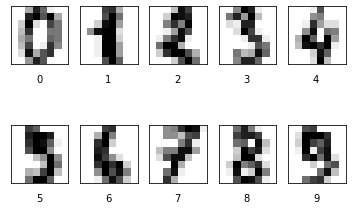

In [9]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [11]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [88]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_test)

(1347, 64)
(450, 64)
(1347,)
(450,)
[1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0
 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1
 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1
 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1
 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0
 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0
 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1
 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 1
 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0
 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0
 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 1 1]


In [87]:
array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
shape_1 = array.reshape((2, 5))
print(shape_1.shape)
print(shape_1)
print(shape_1[0])
print(shape_1[1])
shape_2 = np.array(shape_1[0]).reshape((1, shape_1.shape[1]))
shape_3 = np.array(shape_1[1]).reshape((shape_1.shape[1], 1))
print(shape_2)
print(shape_3)
shape_4 = np.dot(shape_3, shape_2)
print(shape_4)
log_1 = np.log(shape_4)
print(log_1)

(2, 5)
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]]
[1 2 3 4 5]
[ 6  7  8  9 10]
[[1 2 3 4 5]]
[[ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ 6 12 18 24 30]
 [ 7 14 21 28 35]
 [ 8 16 24 32 40]
 [ 9 18 27 36 45]
 [10 20 30 40 50]]
[[1.79175947 2.48490665 2.89037176 3.17805383 3.40119738]
 [1.94591015 2.63905733 3.04452244 3.33220451 3.55534806]
 [2.07944154 2.77258872 3.17805383 3.4657359  3.68887945]
 [2.19722458 2.89037176 3.29583687 3.58351894 3.80666249]
 [2.30258509 2.99573227 3.40119738 3.68887945 3.91202301]]


In [90]:
shape_a = np.array([[1, 2, 3, 4, 5]])
print(shape_a)
print(shape_a.shape)
shape_b = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
print(shape_b)
print(shape_b.shape)
shape_c = np.dot(shape_a, shape_b)
print(shape_c)
print(shape_c.shape)

[[1 2 3 4 5]]
(1, 5)
[[ 1  2]
 [ 3  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]]
(5, 2)
[[ 95 110]]
(1, 2)


#### 3- Architecture of the neural network

![title](./networks.png)

In [4]:
!pwd

/Users/limingxiao/Desktop/NLP_Lectures/jupyters_and_slides/2019-spring


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [50]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s = 1 / (1 + np.exp(-z))
    
    return s

In [51]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [98]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector
    
    Returns:
    w -- initialized vector of shape (dim,1)
    b -- initializaed scalar
    '''
    
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

In [130]:
w_t, b_t = initialize_parameters(64)
print(w_t.shape)
print(w_t.shape[0])
print(w_t.shape[1])

(64, 1)
64
1


#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)}$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}y^{(i)}log(a^{(i)}+(1-y^{(i)})log(1-a^{(i)})$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [176]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    '''
    m = X.shape[0]
    A = sigmoid(np.dot(w.T, X) + b)
    cost = np.sum(-Y * np.log(A) - (1 - Y) * np.log(1 - A)) / m
    
    dw = np.dot(X, (A - Y).T) / m
    db = np.sum(A - Y) / m
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

In [177]:
print(w_t.shape)
propagate(w_t, b_t, X_train.reshape(64, 1347), y_train)

(64, 1)


({'dw': array([[-3.078125 ],
         [ 0.7578125],
         [ 3.90625  ],
         [-3.7421875],
         [ 4.4296875],
         [-1.375    ],
         [-0.671875 ],
         [ 4.0234375],
         [-3.0390625],
         [ 2.921875 ],
         [ 2.0546875],
         [-0.03125  ],
         [ 3.484375 ],
         [-0.4921875],
         [-1.46875  ],
         [ 2.8515625],
         [-0.609375 ],
         [ 1.9609375],
         [ 0.6640625],
         [-1.1796875],
         [ 3.2578125],
         [ 0.4453125],
         [ 1.1484375],
         [ 4.578125 ],
         [-2.8359375],
         [ 2.1640625],
         [-1.3359375],
         [-0.5625   ],
         [ 2.78125  ],
         [-0.28125  ],
         [ 0.0078125],
         [ 1.234375 ],
         [-1.2421875],
         [ 0.125    ],
         [ 1.3984375],
         [-1.8203125],
         [ 4.078125 ],
         [ 1.7109375],
         [-0.7578125],
         [ 1.0078125],
         [-0.8359375],
         [ 0.375    ],
         [ 0.4609375],
     

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [179]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        print(w)
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

In [180]:
optimize(w_t, b_t, X_train.reshape(64, 1347), y_train, num_iterations=2000, learning_rate=0.1,print_cost=False)

[[ 0.3078125 ]
 [-0.07578125]
 [-0.390625  ]
 [ 0.37421875]
 [-0.44296875]
 [ 0.1375    ]
 [ 0.0671875 ]
 [-0.40234375]
 [ 0.30390625]
 [-0.2921875 ]
 [-0.20546875]
 [ 0.003125  ]
 [-0.3484375 ]
 [ 0.04921875]
 [ 0.146875  ]
 [-0.28515625]
 [ 0.0609375 ]
 [-0.19609375]
 [-0.06640625]
 [ 0.11796875]
 [-0.32578125]
 [-0.04453125]
 [-0.11484375]
 [-0.4578125 ]
 [ 0.28359375]
 [-0.21640625]
 [ 0.13359375]
 [ 0.05625   ]
 [-0.278125  ]
 [ 0.028125  ]
 [-0.00078125]
 [-0.1234375 ]
 [ 0.12421875]
 [-0.0125    ]
 [-0.13984375]
 [ 0.18203125]
 [-0.4078125 ]
 [-0.17109375]
 [ 0.07578125]
 [-0.10078125]
 [ 0.08359375]
 [-0.0375    ]
 [-0.04609375]
 [-0.0953125 ]
 [-0.2109375 ]
 [ 0.11640625]
 [ 0.41953125]
 [-0.31171875]
 [ 0.27734375]
 [-0.17578125]
 [-0.11640625]
 [ 0.325     ]
 [ 0.040625  ]
 [ 0.040625  ]
 [ 0.43125   ]
 [-0.35      ]
 [ 0.2703125 ]
 [-0.31015625]
 [-0.41484375]
 [ 0.3578125 ]
 [-0.03984375]
 [ 0.065625  ]
 [-0.0140625 ]
 [-0.36484375]]
[[-1.46141616e+00]
 [ 2.04593606e+00]
 

/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


[[ 13.57934795]
 [  7.35616081]
 [-12.95287304]
 [ 18.0895211 ]
 [-13.36244196]
 [  8.14173806]
 [  5.68917841]
 [ -6.44588165]
 [ 10.72734443]
 [-11.31155417]
 [ -5.12639995]
 [ -9.06927327]
 [ -3.52589121]
 [  8.95121624]
 [  8.46638959]
 [ -5.7085277 ]
 [ -2.5095328 ]
 [ -5.36861003]
 [ 11.15601027]
 [ -3.62031958]
 [ -5.84488696]
 [ -2.40080678]
 [-15.81480955]
 [ -9.50994186]
 [  6.76873975]
 [ -1.55899733]
 [ 21.10085859]
 [ -6.17185544]
 [  1.30932237]
 [ -4.46825939]
 [ -0.86395388]
 [ 13.72934767]
 [  3.10714704]
 [  9.09958362]
 [  7.18475394]
 [  0.42874481]
 [ -6.07361468]
 [-10.54271887]
 [  0.40724496]
 [ 14.68266185]
 [ -6.30578367]
 [  9.97565972]
 [ 10.12215603]
 [-21.9989075 ]
 [  9.26253162]
 [  5.28899937]
 [ 30.23000176]
 [  1.53802092]
 [ 10.35355251]
 [  1.69640038]
 [  1.59708797]
 [ 12.1536529 ]
 [ 24.15041563]
 [  1.2493197 ]
 [ 30.04214248]
 [ -2.92862171]
 [  7.83752192]
 [-11.41800771]
 [-22.40784795]
 [ 14.68021974]
 [ 16.82959967]
 [  6.50742256]
 [ -9.82

[[ 13.65220124]
 [  6.55011429]
 [-13.85881327]
 [ 18.15040716]
 [-13.85333803]
 [  7.93598358]
 [  4.64028386]
 [ -7.74534462]
 [ 10.79889606]
 [-11.76640072]
 [ -5.06635024]
 [ -7.48345331]
 [ -5.51612488]
 [  9.68341625]
 [ 10.4875381 ]
 [ -7.8431051 ]
 [ -1.54157262]
 [ -5.02073426]
 [ 10.5792662 ]
 [ -3.11967969]
 [ -8.71418546]
 [ -1.28227131]
 [-18.66558192]
 [ -8.81044517]
 [  5.80153754]
 [ -2.56705575]
 [ 21.76771005]
 [ -5.93177626]
 [  2.51286601]
 [ -5.60401728]
 [ -0.7049933 ]
 [ 16.6222269 ]
 [  0.05834354]
 [  6.30073247]
 [  8.63651137]
 [ -0.42336655]
 [ -6.45572982]
 [-12.19024791]
 [ -0.55213374]
 [ 13.90096104]
 [ -5.86101729]
 [ 10.37682684]
 [ 10.30150191]
 [-24.14529131]
 [ 11.95792041]
 [  4.62000806]
 [ 31.17254936]
 [  1.58651253]
 [ 10.49604147]
 [  0.6655612 ]
 [  1.83246662]
 [ 11.74925302]
 [ 29.87655154]
 [  0.32034253]
 [ 30.8260479 ]
 [ -3.84876537]
 [  7.57032981]
 [-11.35207806]
 [-24.39790497]
 [ 16.03780266]
 [ 19.19504301]
 [  7.62213327]
 [-11.03

[[  9.63387308]
 [  2.42533153]
 [-18.48424174]
 [ 14.23075415]
 [-18.39627959]
 [  3.99981673]
 [ -0.72522518]
 [-12.80601054]
 [  6.6798138 ]
 [-15.33933068]
 [ -9.23223048]
 [-11.28422668]
 [-10.53271267]
 [  5.11954028]
 [  7.45121922]
 [-12.72655911]
 [ -5.80400051]
 [ -9.84537466]
 [  5.78964096]
 [ -7.08641321]
 [-12.61519604]
 [ -5.01410032]
 [-23.86948994]
 [-12.54703867]
 [  0.99592876]
 [ -8.38223855]
 [ 17.16891584]
 [ -9.93941   ]
 [ -1.1568732 ]
 [-10.1390943 ]
 [ -5.54064155]
 [ 12.99931441]
 [ -5.20630529]
 [  1.12218005]
 [  4.72404516]
 [ -4.66376885]
 [-11.29575119]
 [-17.23384253]
 [ -5.47120857]
 [  9.2158304 ]
 [ -9.83263035]
 [  5.87376495]
 [  5.31209375]
 [-28.32667813]
 [  8.51462677]
 [  0.06989651]
 [ 26.76581794]
 [ -3.59272048]
 [  6.59649602]
 [ -4.87489886]
 [ -2.66099958]
 [  7.37030895]
 [ 26.62339374]
 [ -4.3355411 ]
 [ 25.94647986]
 [ -9.15325687]
 [  3.46290857]
 [-15.1841112 ]
 [-29.32216039]
 [ 12.17039962]
 [ 14.69461659]
 [  2.929281  ]
 [-15.98

[[ 9.81449338e+00]
 [ 2.46126870e+00]
 [-1.91209564e+01]
 [ 1.43361895e+01]
 [-1.86264070e+01]
 [ 4.09515811e+00]
 [-1.19259205e+00]
 [-1.28764082e+01]
 [ 6.93813590e+00]
 [-1.52712258e+01]
 [-8.94920114e+00]
 [-1.10901074e+01]
 [-1.06275255e+01]
 [ 4.92918718e+00]
 [ 7.96462565e+00]
 [-1.29218762e+01]
 [-5.79531725e+00]
 [-9.80099418e+00]
 [ 5.92063567e+00]
 [-6.54117937e+00]
 [-1.22482631e+01]
 [-4.59697889e+00]
 [-2.45006511e+01]
 [-1.17724235e+01]
 [ 6.64199093e-01]
 [-9.02174394e+00]
 [ 1.70649436e+01]
 [-1.00309395e+01]
 [-6.17834914e-01]
 [-1.01401355e+01]
 [-5.47670138e+00]
 [ 1.34952151e+01]
 [-5.90763768e+00]
 [ 6.58264535e-01]
 [ 4.76076911e+00]
 [-4.14698337e+00]
 [-1.13277795e+01]
 [-1.77341052e+01]
 [-5.46997577e+00]
 [ 9.41409442e+00]
 [-9.57500797e+00]
 [ 5.57799332e+00]
 [ 4.82716285e+00]
 [-2.80716841e+01]
 [ 8.85395989e+00]
 [ 2.25401347e-02]
 [ 2.66181585e+01]
 [-3.73046451e+00]
 [ 6.59880713e+00]
 [-5.48946030e+00]
 [-2.83290598e+00]
 [ 7.02431553e+00]
 [ 2.6893622

[[ 1.44539883e+01]
 [ 6.90137453e+00]
 [-1.51209883e+01]
 [ 1.86994450e+01]
 [-1.42665852e+01]
 [ 8.81991574e+00]
 [ 3.14138727e+00]
 [-8.23620873e+00]
 [ 1.17032060e+01]
 [-1.08903842e+01]
 [-4.17860624e+00]
 [-6.91301414e+00]
 [-6.17488121e+00]
 [ 9.43419264e+00]
 [ 1.25533745e+01]
 [-8.46658600e+00]
 [-1.29665159e+00]
 [-4.98731358e+00]
 [ 1.07600682e+01]
 [-1.85160372e+00]
 [-7.49296994e+00]
 [ 1.26034500e-02]
 [-2.03892290e+01]
 [-6.85795074e+00]
 [ 4.51016867e+00]
 [-4.80017446e+00]
 [ 2.15667499e+01]
 [-5.68732830e+00]
 [ 4.26070708e+00]
 [-5.63305295e+00]
 [-8.28582996e-01]
 [ 1.83377279e+01]
 [-1.89889308e+00]
 [ 4.96536767e+00]
 [ 9.10047956e+00]
 [ 6.31478442e-01]
 [-6.58482673e+00]
 [-1.34788111e+01]
 [-6.25369762e-01]
 [ 1.41671372e+01]
 [-5.10319583e+00]
 [ 9.82609037e+00]
 [ 9.16111021e+00]
 [-2.35909551e+01]
 [ 1.36748655e+01]
 [ 4.49495628e+00]
 [ 3.10683447e+01]
 [ 9.90170257e-01]
 [ 1.10390413e+01]
 [-1.19871315e+00]
 [ 1.80139445e+00]
 [ 1.11538097e+01]
 [ 3.1593243

[[ 1.43980567e+01]
 [ 7.00057252e+00]
 [-1.50311492e+01]
 [ 1.84620087e+01]
 [-1.42424424e+01]
 [ 8.82490451e+00]
 [ 3.05591411e+00]
 [-8.14051429e+00]
 [ 1.15769872e+01]
 [-1.07590004e+01]
 [-4.08001118e+00]
 [-6.99290086e+00]
 [-6.00916882e+00]
 [ 9.27797568e+00]
 [ 1.26374411e+01]
 [-8.36418998e+00]
 [-1.35137716e+00]
 [-4.87140088e+00]
 [ 1.09446575e+01]
 [-1.68014872e+00]
 [-7.22166271e+00]
 [ 3.04923039e-02]
 [-2.05528879e+01]
 [-6.32125092e+00]
 [ 4.13269205e+00]
 [-4.96237322e+00]
 [ 2.13757603e+01]
 [-5.77936022e+00]
 [ 4.40742399e+00]
 [-5.48588736e+00]
 [-8.34696623e-01]
 [ 1.85972941e+01]
 [-2.20699018e+00]
 [ 4.79554538e+00]
 [ 9.03673902e+00]
 [ 5.65556133e-01]
 [-6.41016001e+00]
 [-1.36126853e+01]
 [-6.54667373e-01]
 [ 1.43147092e+01]
 [-5.04557601e+00]
 [ 9.89901790e+00]
 [ 9.08033628e+00]
 [-2.36525885e+01]
 [ 1.37849081e+01]
 [ 4.66035700e+00]
 [ 3.08056609e+01]
 [ 1.33998703e+00]
 [ 1.07674324e+01]
 [-1.32145108e+00]
 [ 1.85846958e+00]
 [ 1.08933163e+01]
 [ 3.1719972

[[ 1.46624235e+01]
 [ 7.18548601e+00]
 [-1.52073829e+01]
 [ 1.88237262e+01]
 [-1.44971616e+01]
 [ 9.11269864e+00]
 [ 3.25881435e+00]
 [-8.29001478e+00]
 [ 1.19318002e+01]
 [-1.07671786e+01]
 [-4.12042767e+00]
 [-6.83363454e+00]
 [-6.17533122e+00]
 [ 9.37232532e+00]
 [ 1.30148603e+01]
 [-8.51176216e+00]
 [-1.15260880e+00]
 [-4.65329369e+00]
 [ 1.11219649e+01]
 [-1.18744096e+00]
 [-7.40308981e+00]
 [ 1.28538364e-02]
 [-2.04677978e+01]
 [-6.38805902e+00]
 [ 4.35704024e+00]
 [-5.02464896e+00]
 [ 2.14194504e+01]
 [-5.41523400e+00]
 [ 4.39717579e+00]
 [-5.15339442e+00]
 [-6.01231842e-01]
 [ 1.85672435e+01]
 [-2.09179443e+00]
 [ 4.67934577e+00]
 [ 9.04955727e+00]
 [ 9.38806197e-01]
 [-6.46003781e+00]
 [-1.36409550e+01]
 [-4.51088048e-01]
 [ 1.43245201e+01]
 [-4.76045487e+00]
 [ 9.97658037e+00]
 [ 9.13180791e+00]
 [-2.34098769e+01]
 [ 1.37601187e+01]
 [ 4.85177573e+00]
 [ 3.12223968e+01]
 [ 1.31202137e+00]
 [ 1.09720931e+01]
 [-1.44485051e+00]
 [ 1.86069548e+00]
 [ 1.12380982e+01]
 [ 3.1677835

[[ 14.57493488]
 [  7.27346993]
 [-15.03556798]
 [ 18.64226404]
 [-14.37130411]
 [  9.09487344]
 [  3.15043211]
 [ -8.19886485]
 [ 11.92967946]
 [-10.71215039]
 [ -3.96677615]
 [ -6.84103245]
 [ -5.97820397]
 [  9.32863141]
 [ 13.04709828]
 [ -8.35005754]
 [ -1.09321523]
 [ -4.56158371]
 [ 11.32229576]
 [ -1.09989476]
 [ -7.188359  ]
 [  0.05408313]
 [-20.55757892]
 [ -6.11729904]
 [  4.2480786 ]
 [ -5.0141385 ]
 [ 21.33493331]
 [ -5.4278302 ]
 [  4.51127647]
 [ -5.03976562]
 [ -0.58240783]
 [ 18.7528841 ]
 [ -2.26023302]
 [  4.60361153]
 [  9.09504605]
 [  0.88180473]
 [ -6.38388766]
 [-13.64346506]
 [ -0.55342369]
 [ 14.53439885]
 [ -4.7474627 ]
 [ 10.07786394]
 [  9.16445015]
 [-23.42203484]
 [ 13.90839235]
 [  4.94693227]
 [ 31.08713902]
 [  1.66678549]
 [ 10.71575639]
 [ -1.51323241]
 [  1.9963777 ]
 [ 11.20441389]
 [ 31.71566802]
 [ -0.50808622]
 [ 29.70404347]
 [ -5.44093535]
 [  9.15570426]
 [-10.85142368]
 [-25.98644992]
 [ 16.72882214]
 [ 18.85990588]
 [  6.80675398]
 [-11.69

[[ 14.47244232]
 [  7.15433087]
 [-15.22044524]
 [ 18.48807457]
 [-14.50646222]
 [  9.08890471]
 [  3.01770498]
 [ -8.23519585]
 [ 11.78817083]
 [-10.93309764]
 [ -4.20633391]
 [ -6.86200306]
 [ -6.10063973]
 [  9.05106474]
 [ 12.90017683]
 [ -8.43415518]
 [ -1.1802004 ]
 [ -4.64763777]
 [ 11.21118286]
 [ -1.26483337]
 [ -7.38032143]
 [ -0.10521122]
 [-20.79418292]
 [ -6.26680241]
 [  4.00430972]
 [ -5.25425732]
 [ 21.22499874]
 [ -5.57832704]
 [  4.43653895]
 [ -5.17879959]
 [ -0.77357473]
 [ 18.66947746]
 [ -2.60361831]
 [  4.29531235]
 [  8.9549616 ]
 [  0.58822137]
 [ -6.53918904]
 [-13.87803722]
 [ -0.76902696]
 [ 14.50547612]
 [ -4.94594195]
 [ 10.04115382]
 [  8.99887303]
 [-23.68554087]
 [ 13.70057185]
 [  4.81990987]
 [ 30.99576387]
 [  1.62279233]
 [ 10.41189929]
 [ -1.70717521]
 [  1.86147276]
 [ 10.86215282]
 [ 31.64962396]
 [ -0.77985081]
 [ 29.60256215]
 [ -5.64644387]
 [  8.91204868]
 [-11.03049936]
 [-26.1922518 ]
 [ 16.4386891 ]
 [ 18.66032136]
 [  6.64347556]
 [-11.86

[[ 1.47137464e+01]
 [ 7.35876431e+00]
 [-1.50877504e+01]
 [ 1.87560979e+01]
 [-1.44625904e+01]
 [ 9.28964948e+00]
 [ 3.25768985e+00]
 [-8.15346456e+00]
 [ 1.20476771e+01]
 [-1.07937971e+01]
 [-4.12919930e+00]
 [-6.61516961e+00]
 [-5.92005276e+00]
 [ 9.22589043e+00]
 [ 1.30991174e+01]
 [-8.28688930e+00]
 [-9.38676470e-01]
 [-4.43101128e+00]
 [ 1.14554471e+01]
 [-8.98516768e-01]
 [-7.28626076e+00]
 [ 1.59704705e-02]
 [-2.06101636e+01]
 [-6.15455624e+00]
 [ 4.19965515e+00]
 [-5.02716492e+00]
 [ 2.13090347e+01]
 [-5.31169819e+00]
 [ 4.50776428e+00]
 [-4.88075526e+00]
 [-5.78362950e-01]
 [ 1.87899859e+01]
 [-2.43530215e+00]
 [ 4.37960937e+00]
 [ 9.07956161e+00]
 [ 9.00956086e-01]
 [-6.47547828e+00]
 [-1.37621956e+01]
 [-5.24671135e-01]
 [ 1.45998707e+01]
 [-4.70374551e+00]
 [ 1.02141991e+01]
 [ 9.14447512e+00]
 [-2.33561609e+01]
 [ 1.38143575e+01]
 [ 4.99355883e+00]
 [ 3.12238470e+01]
 [ 1.78489432e+00]
 [ 1.05168120e+01]
 [-1.68180719e+00]
 [ 2.03900567e+00]
 [ 1.11891664e+01]
 [ 3.1650962

[[ 10.10094828]
 [  2.88987063]
 [-19.25771341]
 [ 14.12195647]
 [-18.91995097]
 [  4.57929489]
 [ -1.51364517]
 [-12.8337739 ]
 [  7.38911766]
 [-15.23494423]
 [ -8.85403774]
 [-11.08686574]
 [-10.4321523 ]
 [  4.64233499]
 [  8.60042722]
 [-12.86129702]
 [ -5.60033526]
 [ -9.31356969]
 [  6.8652525 ]
 [ -5.49261649]
 [-11.86169723]
 [ -4.66526795]
 [-25.43800438]
 [-10.72182276]
 [ -0.30284401]
 [ -9.76298063]
 [ 16.66120035]
 [ -9.80436747]
 [ -0.10465303]
 [ -9.18075393]
 [ -5.36395934]
 [ 14.03402731]
 [ -7.17451031]
 [ -0.27515437]
 [  4.5232165 ]
 [ -3.96811427]
 [-11.16705688]
 [-18.39728293]
 [ -5.42574995]
 [ 10.07400798]
 [ -9.18601757]
 [  5.76811266]
 [  4.58529887]
 [-28.08567018]
 [  8.92453054]
 [  0.50090651]
 [ 26.41343863]
 [ -2.75013471]
 [  5.69135669]
 [ -6.28864699]
 [ -2.6161935 ]
 [  6.39521966]
 [ 27.02186812]
 [ -5.25962754]
 [ 25.22424039]
 [-10.37114704]
 [  4.50437621]
 [-15.41861478]
 [-30.65586033]
 [ 12.15623786]
 [ 13.98108947]
 [  1.90282938]
 [-16.18

[[ 14.67190072]
 [  7.36696256]
 [-14.99495995]
 [ 18.6330177 ]
 [-14.49546847]
 [  9.26616148]
 [  3.19401343]
 [ -8.1032113 ]
 [ 12.14683178]
 [-10.83248257]
 [ -4.08998047]
 [ -6.636731  ]
 [ -5.86757112]
 [  9.22158806]
 [ 13.18255548]
 [ -8.23577828]
 [ -0.84675871]
 [ -4.48743512]
 [ 11.49122431]
 [ -0.78073927]
 [ -7.19362214]
 [ -0.05004875]
 [-20.68525723]
 [ -6.15851581]
 [  4.09465922]
 [ -5.07762812]
 [ 21.22686461]
 [ -5.34694552]
 [  4.62691837]
 [ -4.82035808]
 [ -0.58140772]
 [ 18.85489465]
 [ -2.62635252]
 [  4.36558755]
 [  9.12263616]
 [  0.88035983]
 [ -6.49028631]
 [-13.85742735]
 [ -0.57531826]
 [ 14.59670599]
 [ -4.67502991]
 [ 10.22799754]
 [  9.2168251 ]
 [-23.37999093]
 [ 13.86830622]
 [  4.99084478]
 [ 31.14493075]
 [  1.90822909]
 [ 10.46381133]
 [ -1.78763989]
 [  2.10360328]
 [ 11.22084254]
 [ 31.68248833]
 [ -0.69923032]
 [ 29.89550811]
 [ -5.5673241 ]
 [  9.24499675]
 [-10.9457458 ]
 [-26.18258618]
 [ 16.58759363]
 [ 18.61627328]
 [  6.653668  ]
 [-11.74

[[ 14.65185693]
 [  7.35868856]
 [-14.89552856]
 [ 18.52405761]
 [-14.37445168]
 [  9.22151333]
 [  3.19458989]
 [ -8.12500563]
 [ 12.12916338]
 [-10.8051482 ]
 [ -4.08408931]
 [ -6.65526561]
 [ -5.86871205]
 [  9.17422498]
 [ 13.32759861]
 [ -8.14393626]
 [ -0.85895434]
 [ -4.46781829]
 [ 11.47495471]
 [ -0.78786876]
 [ -7.09622214]
 [ -0.10822126]
 [-20.74961358]
 [ -6.07967539]
 [  4.01320972]
 [ -5.07841082]
 [ 21.22865136]
 [ -5.42176245]
 [  4.71588907]
 [ -4.72443199]
 [ -0.61415306]
 [ 18.88983754]
 [ -2.64604219]
 [  4.42270636]
 [  9.09064234]
 [  0.90591887]
 [ -6.49402023]
 [-13.86320336]
 [ -0.62600159]
 [ 14.68685767]
 [ -4.67289837]
 [ 10.24582094]
 [  9.23085997]
 [-23.41040752]
 [ 13.97276031]
 [  5.03596495]
 [ 31.03408717]
 [  2.01144357]
 [ 10.36522472]
 [ -1.78640529]
 [  2.12559   ]
 [ 11.22505404]
 [ 31.66365324]
 [ -0.66371035]
 [ 29.81890557]
 [ -5.52061341]
 [  9.24905028]
 [-10.93707863]
 [-26.16292779]
 [ 16.53113833]
 [ 18.60977557]
 [  6.6661341 ]
 [-11.68

[[ 10.11087749]
 [  2.9427945 ]
 [-19.18670166]
 [ 13.94799689]
 [-18.93540442]
 [  4.53888915]
 [ -1.44744216]
 [-12.7613902 ]
 [  7.42016085]
 [-15.25673838]
 [ -8.827566  ]
 [-11.0057955 ]
 [-10.30096407]
 [  4.5222079 ]
 [  8.73288648]
 [-12.74418354]
 [ -5.4386533 ]
 [ -9.29497589]
 [  6.89858944]
 [ -5.44626279]
 [-11.76243283]
 [ -4.70529333]
 [-25.521729  ]
 [-10.68708067]
 [ -0.45654859]
 [ -9.79244787]
 [ 16.5640791 ]
 [ -9.84372491]
 [  0.04644864]
 [ -9.15821434]
 [ -5.3097755 ]
 [ 14.17371541]
 [ -7.36495804]
 [ -0.28038768]
 [  4.53631382]
 [ -3.95928762]
 [-11.21436001]
 [-18.51191871]
 [ -5.4730996 ]
 [ 10.11263812]
 [ -9.17736938]
 [  5.86212801]
 [  4.68784568]
 [-28.08584922]
 [  9.01814994]
 [  0.50175512]
 [ 26.33818126]
 [ -2.55254182]
 [  5.58824418]
 [ -6.3695399 ]
 [ -2.55862998]
 [  6.42338302]
 [ 27.16569913]
 [ -5.34987063]
 [ 25.20614984]
 [-10.44203247]
 [  4.54986273]
 [-15.36986634]
 [-30.73258599]
 [ 11.99781389]
 [ 13.9963581 ]
 [  1.83238772]
 [-16.17

({'w': array([[ 14.46587343],
         [  7.19466585],
         [-15.12573045],
         [ 18.44130348],
         [-14.6561143 ],
         [  9.12354013],
         [  3.03209883],
         [ -8.25802776],
         [ 11.9440897 ],
         [-11.05571342],
         [ -4.38889323],
         [ -6.80404233],
         [ -6.00031579],
         [  9.00004826],
         [ 12.98546117],
         [ -8.2954534 ],
         [ -0.9701146 ],
         [ -4.56661071],
         [ 11.42857661],
         [ -0.91694796],
         [ -7.43661171],
         [ -0.27211886],
         [-20.93272346],
         [ -6.27046824],
         [  3.90288109],
         [ -5.2202733 ],
         [ 21.19485771],
         [ -5.54213812],
         [  4.57555802],
         [ -4.92998428],
         [ -0.74888121],
         [ 18.69119326],
         [ -2.9476976 ],
         [  4.14151811],
         [  8.87977219],
         [  0.63438624],
         [ -6.66330402],
         [-14.15920826],
         [ -0.7750945 ],
         [ 14.561184

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [152]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            Y_prediction[0, i] = 1
        else:
            Y_prediction[0, i] = 0
    
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

In [153]:
predict(w_t, b_t, X_train.reshape(64, 1347))

array([[0., 0., 0., ..., 0., 0., 0.]])

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [157]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    dim = X_train.shape[0]
    w, b = initialize_parameters(dim)
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    training_accuracy = predict(w, b, X_train)
    test_accuracy = predict(w, b, X_test)
    d = {
        "w": w,
        "b": b,
        "training_accuracy": training_accuracy,
        "test_accuracy": test_accuracy,
        "costs": costs
    }
    return d

In [158]:
model(X_train.reshape(64, 1347), y_train, X_test.reshape(64, 450), y_test, num_iterations=2000, learning_rate=0.1,print_cost=False)

/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/Users/orange/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


{'w': array([[ 14.46587343],
        [  7.19466585],
        [-15.12573045],
        [ 18.44130348],
        [-14.6561143 ],
        [  9.12354013],
        [  3.03209883],
        [ -8.25802776],
        [ 11.9440897 ],
        [-11.05571342],
        [ -4.38889323],
        [ -6.80404233],
        [ -6.00031579],
        [  9.00004826],
        [ 12.98546117],
        [ -8.2954534 ],
        [ -0.9701146 ],
        [ -4.56661071],
        [ 11.42857661],
        [ -0.91694796],
        [ -7.43661171],
        [ -0.27211886],
        [-20.93272346],
        [ -6.27046824],
        [  3.90288109],
        [ -5.2202733 ],
        [ 21.19485771],
        [ -5.54213812],
        [  4.57555802],
        [ -4.92998428],
        [ -0.74888121],
        [ 18.69119326],
        [ -2.9476976 ],
        [  4.14151811],
        [  8.87977219],
        [  0.63438624],
        [ -6.66330402],
        [-14.15920826],
        [ -0.7750945 ],
        [ 14.56118478],
        [ -4.94199583],
        [ 1

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digit (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 